# GSA coursework

In this coursework you will have to discuss how changes in precipitation due to climate change might impact streamflow (in the specific the frequency of high flows) in the future. You will have also to assess the impact of the uncertainty in the model input factors on the model output.

The uncertain inputs subject to SA are the model parameters and forcing input (precipitation). 

Brief description of what an hydrological model is:

Imagine that we want to predict the water flows that drain into a river from the amount of rainfall that has fallen in the river catchment area. For this purpose, we can use a hydrological model, which describes the hydrological processes occuring in the catchment (such as evaporation, surface and underground flows, etc.) via a set of equations. These equations encompass various parameters, describing the properties of the catchment, such as the vegetation and soil characteristics.

<left><img src="images/rain_runoff_diagram8.gif" width="700px">

Above: schematic of the main hydrological processes occuring in a catchment. Below: schematic of how the processes are represented in a hydrological model to finally predict the river flow.

<left><img src="images/rain_runoff_param.png" width="400px">


**Hymod model**:

We will use the hydrological model Hymod (Boyle 2001; Wagener et al. 2001) model, which
produces a time series of streamflow predictions as output. The model is
composed of a soil moisture accounting routine, and a flow routing routine,
which in its turn is composed of a fast and a slow routing pathway.

A schematic of the conceptual hydrological model is shown below with parameters highlighted in orange.

![hymod_model](images/hymod_model.png)

The model inputs that will be investigated for their influence on the output are:
- **Sm**: soil storage capacity (capacity of the soil to store rainwater) (mm) 
- **beta**: the exponent in the soil moisture component (proportion of the rainwater that evaporates)  (-) 
- **alfa**: the partition coefficient between surface (fast) and underground (slow) flow (-) 
- **Rs**: the slow reservoir coefficient (average time for the surface water to reach the river) (-)
- **Rf**: the fast reservoir coefficient (average time for the undergound water to reach the river) (-) 
- **rain_e**: multiplictive factor applied to the precipitation time series (-)

The model forcing input data are:
- 1-year daily observations of rainfall (R) [column 1 in LeafCatch.txt]
- 1-year daily observations of potential evaporation (PE) [column 2 in the file
LeafCatch.txt]

We will also used output measurements:
- 1-year daily observations of streamflow (Q) [column 3 in LeafCatch.txt]

We will consider three performance metrics:
- the Root Mean Squared Error (RMSE)
- the volumetric bias (BIAS)
- the frequency of High Flow Days    

For this application, we can use the following ranges of feasible variations of the input factors:
- SM ∈ [0,400] (mm)
- beta ∈ [0,2] (-)
- alfa ∈ [0,1] (-)
- RS ∈ [0,0.1] (-)
- RF ∈ [0.1,1] (-)
- rain_e ∈ [0.6 - 1.4] (-) [i.e. change in precipitation of +/- 40%]

The model is applied to the Leaf catchment in the USA (Sorooshian et al., 1983).

![leaf_catchment](images/leaf_catchment.png)


## Import libraries

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from __future__ import division, absolute_import, print_function

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatRangeSlider, IntRangeSlider
import scipy.stats as st

import warnings
warnings.filterwarnings('ignore') # to hide warning messages

# Module to perform Regional Sensitivity Analysis:
import SAFEpython.RSA_thres as RSA_tr
# Module to perform Regional Sensitivity Analysis based on grouping:
import SAFEpython.RSA_groups as RSA_gp
# Module to visualize the results:
import SAFEpython.plot_functions as pf
# Module to execute the model
from SAFEpython.model_execution import model_execution
# Functions to perform the input sampling
from SAFEpython.sampling import AAT_sampling, AAT_sampling_extend
# Function to calculate RMSE:
from SAFEpython.util import aggregate_boot, RMSE
# Module that simulates the HyMod model:
from SAFEpython import HyMod

# Import the additional function BIAS in the BIAS.py module
from BIAS import BIAS

## 1. Model setup 

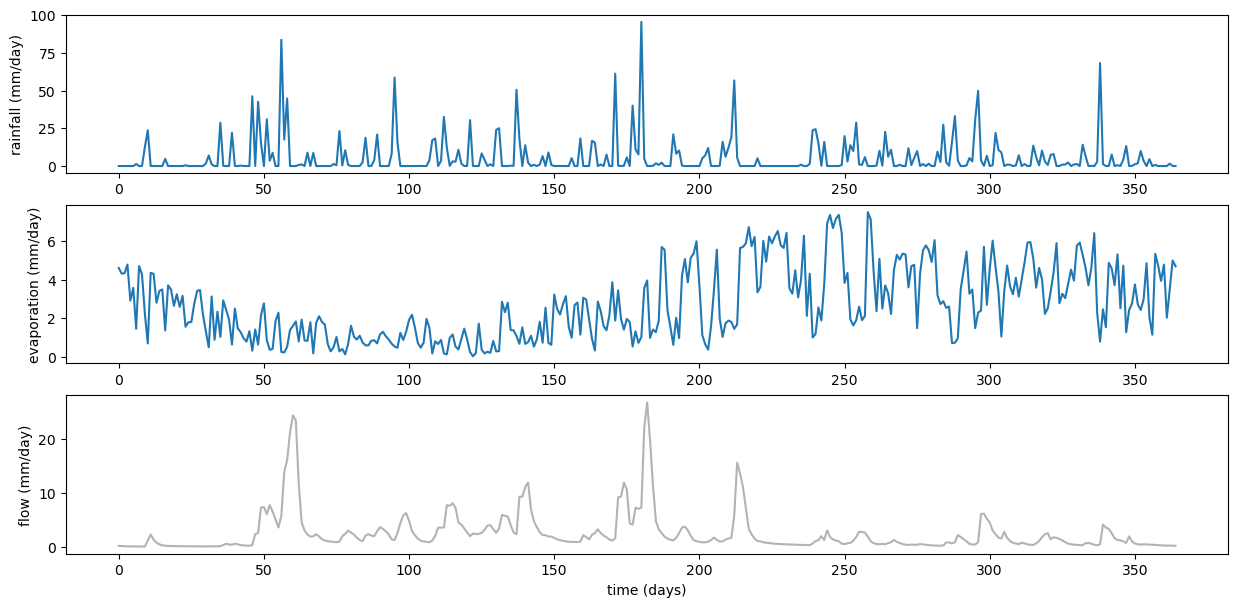

In [3]:
# Specify the directory where the data are stored 
mydir = 'data'

# Load data and plot the data (one year of daily observations of rainfall, 
# potential evaporation and flow):

# Load data:
data = np.genfromtxt(mydir +'//LeafCatch.txt', comments='%')
rain = data[0:365, 0] # select the first year of data
evap = data[0:365, 1]
flow = data[0:365, 2]
warmup = 30 # Model warmup period (days)

# Plot data:
plt.figure(figsize=[15,7])
plt.subplot(311); plt.plot(rain); plt.ylabel('rainfall (mm/day)')
plt.subplot(312); plt.plot(evap); plt.ylabel('evaporation (mm/day)')
plt.subplot(313); plt.plot(flow, color=[0.7, 0.7, 0.7]); plt.ylabel('flow (mm/day)')
plt.xlabel('time (days)')
plt.show()

In this section, we run Monte Carlo (MC) simulations of the model against a certain number of input samples. Each model simulation provides a times series of runoff predictions. 

We want to investigate the impact on the model predictions of the uncertainty in the parameters and the errors in rainfall measurements. 

This requires modifying the model and re-running the model (WARNING: it may take some time to run this line).

In [4]:
def hymod_sim_workshop_mod(inputs, rain, ept):
    
    """This function simulates the Hymod rainfall-runoff model
    (Boyle, 2001; Wagener et al., 2001). 
    It is modified from HyMod.hymod_sim in the SAFE package"""

    ###########################################################################
    # Recover model input factors
    ###########################################################################
    Sm = max(np.spacing(1), inputs[0]) # Maximum Soil Moisture (cannot
                                              # be zero! ) 
    beta = inputs[1] # Exponential parameter in soil routine [-]
    alfa = inputs[2] # Partitioning factor [-]
    Rs = inputs[3] # Slow reservoir outflow coefficient (ratio) [1/Dt]
    Rf = inputs[4] # Fast reservoir outflow coefficient (ratio) [1/Dt]
    rain_e = inputs[5] #  Error in precipitation time series [-]

    T = len(rain)

    ###########################################################################
    # Initialise variables
    ###########################################################################
    Pe = np.zeros((T, )) # Recharge from the soil [mm/Dt]
    Ea = np.zeros((T, )) # Actual Evapotranspiration [mm/Dt]
    sm = np.zeros((T+1, )) # Soil Moisture [mm]
    sL = np.zeros((T+1, )) # Slow reservoir moisture [mm]
    sF1 = np.zeros((T+1, )) # Fast reservoir 1 moisture [mm]
    sF2 = np.zeros((T+1, )) # Fast reservoir 2 moisture [mm]
    sF3 = np.zeros((T+1, )) # Fast reservoir 3 moisture [mm]
    QsL = np.zeros((T, )) # Slow flow [mm/Dt]
    QsF = np.zeros((T, )) # Fast flow [mm/Dt]

    for t in range(T):
    ###########################################################################
    # Soil moisture dynamics
    ###########################################################################
        F = 1 - (1-sm[t]/Sm)**beta
        Pe[t] = F * rain[t] * rain_e # Compute the value of the outflow
        # (we assumed that this process is faster than evaporation)
        sm_temp = max(min(sm[t] + rain[t] * rain_e - Pe[t], Sm), 0)
        # Compute the water balance with the value of the outflow
        Pe[t] = Pe[t] + max(sm[t] + rain[t] * rain_e - Pe[t] - Sm, 0) + \
                min(sm[t] + rain[t] * rain_e - Pe[t], 0)
        # Adjust Pe by an amount equal to the possible negative sm amount or
        # to the possible sm amount above Sm.

        W = min(np.abs(sm[t]/Sm), 1) # Correction factor for evaporation
        Ea[t] = W * ept[t] # Compute the evaporation
        sm[t+1] = max(min(sm_temp - Ea[t], Sm), 0) # Compute the water balance
        Ea[t] = Ea[t] + max(sm_temp - Ea[t] - Sm, 0) + min(sm_temp - Ea[t], 0)
        # Adjust Ea by an amount equal to the possible negative sm amount or to
        # the possible sm amount above Sm.

    ###########################################################################
    # Groundwater dynamics
    ###########################################################################
        # slow flow
        QsL[t] = Rs * sL[t]
        sL[t+1] = sL[t] + (1-alfa)*Pe[t] - QsL[t]
        # fast flow
        sF1[t+1] = sF1[t] +  alfa*Pe[t] - Rf*sF1[t]
        sF2[t+1] = sF2[t] +  Rf*sF1[t] - Rf*sF2[t]
        sF3[t+1] = sF3[t] +  Rf*sF2[t] - Rf*sF3[t]
        QsF[t] = Rf * sF3[t]

    Q_sim = QsL + QsF
    STATES = np.column_stack((sm, sL, sF1, sF2, sF3))
    FLUXES = np.column_stack((Pe, Ea, QsL, QsF))

    return Q_sim, STATES, FLUXES


def oat_function(Sm = 200, beta = 0.5, alpha = 0.7, Rs = 0.05, Rf = 0.6, rain_e = 1):
    # Set a tentative parameterization:
    inputs = np.array([Sm, beta, alpha, Rs, Rf, rain_e]) # Sm (mm), beta (-), alfa (-), Rs (-), Rf (-), rain_e (-)
    # Run simulation:
    flow_sim, _, _ = hymod_sim_workshop_mod(inputs, rain, evap)
    # Plot results:
    plt.figure(figsize=[15,3])
    plt.plot(flow, color=[0.7, 0.7, 0.7]) # observed flow
    plt.plot(flow_sim, 'k') # simulated flow
    plt.ylabel('flow (mm/day)')
    plt.xlabel('time (days)')
    plt.legend(['obs', 'sim'])
    plt.show()
    
interact(oat_function, Sm = (0, 400, 1), beta = (0, 2, 0.1), alpha = (0,1,0.1), Rs = (0,0.1,0.01), Rf = (0.1,1,0.1), rain_e = (0.6,1.4));


interactive(children=(IntSlider(value=200, description='Sm', max=400), FloatSlider(value=0.5, description='bet…

Input sampling:

In [20]:
# Define input variability space
X_Labels = ['Sm', 'beta', 'alfa', 'Rs', 'Rf', 'rain_e'] # Name of input factors (used to customize plots)
M = len(X_Labels) # Number of input factors
distr_fun = st.uniform # Input factor distributions
xmin = [0,   0, 0, 0.0, 0.1, 0.6] # Input factor ranges (lower bound)
xmax = [400, 2, 1, 0.1, 1.0, 1.4] # Input factor ranges (upper bound)
# The shape input factor of the uniform distribution are the lower limit and the
# difference between lower and upper limits:
distr_par = [np.nan] * M
for i in range(M):
    distr_par[i] = [xmin[i], xmax[i] - xmin[i]]

# Choose sampling strategy and size:
samp_strat = 'lhs' # sampling strategy
N = 1000 # Choose the number of samples

# Perform sampling:
X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)

# If you want to see what the sample 'X' looks like:
print(X[0:10, :]) # Print to screen the first 10 samples

[[2.61402827e+02 6.70943522e-01 7.95750694e-01 4.90818527e-02
  7.59885187e-01 8.63649720e-01]
 [8.86492868e+01 1.86914010e+00 4.46002098e-01 5.87419340e-02
  3.85827442e-01 7.66992545e-01]
 [1.31087706e+02 1.78804009e+00 9.96331351e-01 4.91809322e-03
  4.68884742e-01 1.22704325e+00]
 [2.32936935e+02 1.99990766e+00 8.59915980e-01 7.27732638e-02
  6.75651051e-01 6.70867534e-01]
 [2.07598471e+02 1.54621655e+00 7.97175348e-01 7.06734944e-02
  9.75936002e-01 6.05067916e-01]
 [1.22632400e+02 1.74341765e+00 6.52424151e-01 4.36920741e-02
  2.12548171e-01 1.14821004e+00]
 [2.83740050e+02 3.12727232e-01 4.74491350e-01 6.56321301e-02
  4.34497322e-01 1.10609819e+00]
 [2.21474766e+02 9.57051108e-01 1.33591929e-01 5.84532402e-02
  4.06498571e-01 7.95215659e-01]
 [3.40558700e+01 8.78723340e-01 3.03011095e-01 8.05786965e-02
  5.14574238e-01 1.04558986e+00]
 [4.21951605e+01 7.92908094e-01 8.38764456e-01 4.65329794e-02
  3.32877258e-01 7.55996108e-01]]


Execute the model against the 6 input factors

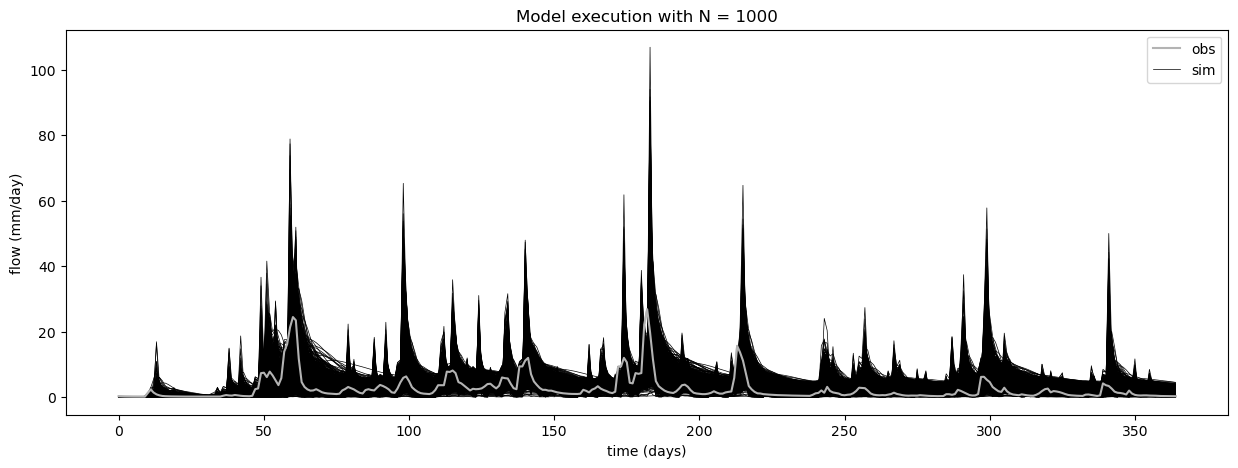

In [21]:
QQ = model_execution(hymod_sim_workshop_mod, X, rain, evap)

# Plot Monte Carlo (MC) simulations results and compare with data:
plt.figure(figsize=[15,5])
plt.plot(flow, color=[0.7, 0.7, 0.7]) # plot for legend
plt.plot(np.transpose(QQ), 'k', linewidth = 0.5)
plt.plot(flow, color=[0.7, 0.7, 0.7])
plt.ylabel('flow (mm/day)'); plt.xlabel('time (days)')
plt.legend(['obs', 'sim'])
plt.title("Model execution with N = %d" % N)
plt.show()

Estimate the 95th percentile of the predicted streamflow

In [22]:
Q95 = np.percentile(QQ,95, axis = 1)

Estimate the 95th percentile of observed streamflow

In [23]:
Q95obs = np.percentile(flow,95)
Q95obs

9.4014

Define new output metric as the frequency of High Flow Days in a year (a day is defined as high flow if it exceeds the 95th percentile of observed streamflow)

In [24]:
HFD = np.sum(QQ >= Q95obs, axis = 1)/365

Aggregate time series into various scalar output metric(s):

In [25]:
YY = np.nan * np.ones((N, 3))
YY[:, 0] = RMSE(QQ[:, warmup:365], flow[warmup:365])
YY[:, 1] = BIAS(QQ[:, warmup:365], flow[warmup:365])
YY[:, 2] = HFD


Estimate the frequency of High Flow Days in the observations (we will need it later as a baseline)

In [26]:
np.sum(flow >= Q95obs)/365

0.0547945205479452

Let's plot the scatter plots of the input samples against their corresponding output metric (you can choose one or the other interactively)  

In [27]:
def output_metric_interact(metric):
    if metric == 'RMSE': 
        i = 0
    elif metric == 'BIAS': 
        i = 1
    elif metric == 'High Flow Days':
        i = 2
    
    Y = YY[:, i]; 
    Y_Label = metric

    # Scatter plots of the output metric against input samples:
    plt.figure(figsize=[15,10])
    pf.scatter_plots(X, Y, Y_Label=Y_Label, X_Labels=X_Labels, n_col =3)
    plt.suptitle("Scatter plots with N = %d" % N + ', ' + Y_Label, y = 0.95)
    plt.show()

aggregate_interact = interact(output_metric_interact, metric = ['RMSE', 'BIAS','High Flow Days'])

interactive(children=(Dropdown(description='metric', options=('RMSE', 'BIAS', 'High Flow Days'), value='RMSE')…

**Questions**:
- What are the input factors that influence the frequency of high flow days the most?
- Do the results change by changing output metric?
- Assuming the Hymod model can be used to explore how streamflow will have in the future in the Leaf catchment due to changes in precipation, what is the range of variation in the frequency of high flow days that we can expect given the increase in rainfall intensity you derived from your previous answers (following Tom's questions)? How does this compare to the range of variation in the present?


Estimate the sensitivity indices with the Regional Sensitivity Analysis method

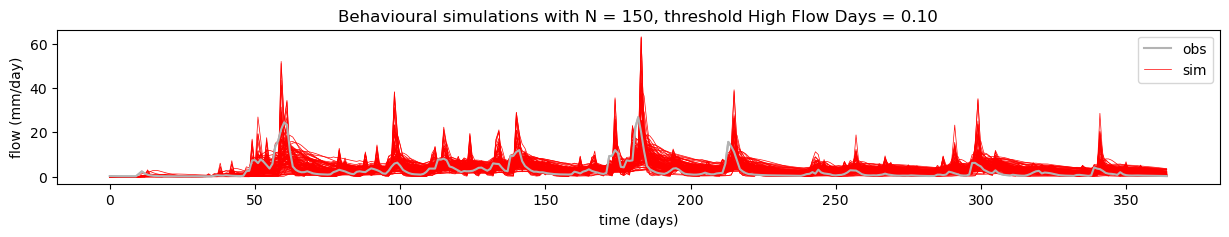

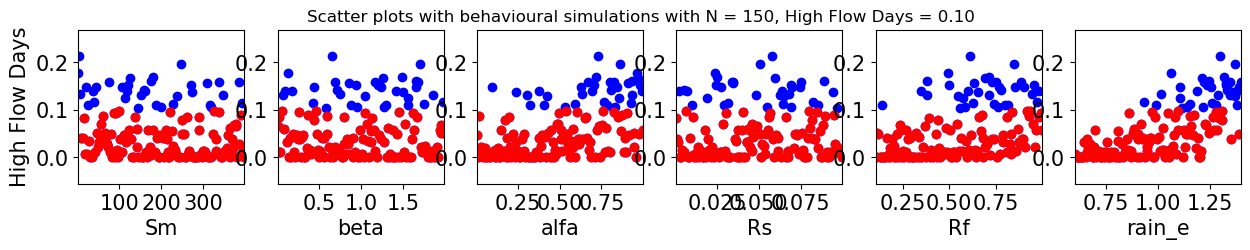

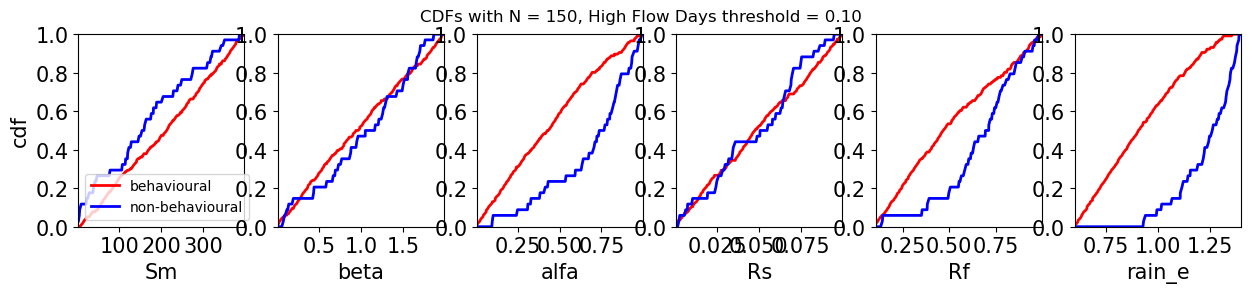

Value of the KS statistics between the two CDFs of the inputs: [0.20740365 0.13539554 0.44726166 0.14959432 0.38894523 0.63742394]


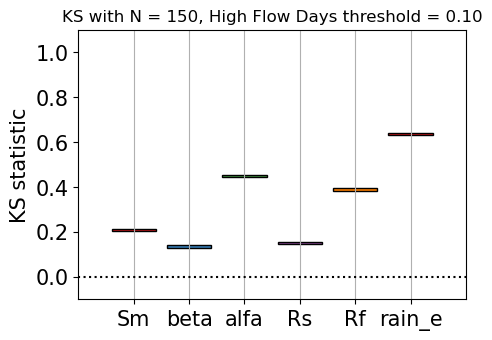

In [13]:
def RSA_function(metric = 'High Flow Days',threshold = 0.1):
    
    # Select the index of the output of interest:
    if metric == 'RMSE': 
        i = 0
    elif metric == 'BIAS': # for BIAS threshold higher than 2.5 you get an error
        i = 1
    elif metric == 'High Flow Days':
        i = 2
    
    # Extract output of interest:
    Y = YY[:, i]
    
    # Check that there are values below the threshold, otherwise plot a warning message
    if np.all(np.logical_not(Y<threshold)):
        print('Cannot find any output value below the threshold! Try increasing the threshold value')
    
    # Check that there are value above the threshold, otherwise plot a warning message
    elif np.all(Y<threshold):
        print('Cannot find any output value above the threshold! Try reducing the threshold value')
    
    # Perform RSA if there are values both below and above the threshold:
    else:
        Y_Label = metric

        # Use the function RSA_indices_thres to split into behavioural (Y<threshold)
        # and non-behavioural (Y>threshold) sample:
        mvd, _, _, idxb = RSA_tr.RSA_indices_thres(X, Y, threshold)
        # To learn what the function 'RSA_indices_thres' does, type:
        # help(RSA_tr.RSA_indices_thres)
        # idxb: indices of behavioural samples

        # Plot behavioural MC simulations:
        QQb = QQ[idxb, :]
        plt.figure(figsize=[15,2])
        plt.plot(flow, color=[0.7, 0.7, 0.7]) # plot for legend
        plt.plot(np.transpose(QQb), 'r', linewidth = 0.5);
        plt.plot(flow, color=[0.7, 0.7, 0.7])
        plt.ylabel('flow (mm/day)'); plt.xlabel('time (days)')
        plt.legend(['obs', 'sim'])
        plt.title("Behavioural simulations with N = %d" % N + ', threshold ' + Y_Label + ' = %2.2f' % threshold)
        plt.show()

        # Replot the results with the function `scatter_plots` highlighting the
        # behavioural parameterizations:
        plt.figure(figsize=[15,2])
        pf.scatter_plots(X, Y, Y_Label=Y_Label, X_Labels=X_Labels, idx=idxb, n_col = 6)
        plt.suptitle("Scatter plots with behavioural simulations with N = %d" % N + ', ' + Y_Label  + " = %2.2f" % threshold)
        plt.show()
        # (red = behavioural, blue = non-behavioural)

        # Plot CDFs of behavioural and non-behavioural input samples: 
        fig_cdfs = RSA_tr.RSA_plot_thres(X, idxb, X_Labels=X_Labels, n_col = 6)
        plt.suptitle("CDFs with N = %d" % N + ', ' + Y_Label + " threshold = %2.2f" % threshold)
        hfig_cdfs = plt.gcf() # get figure handle
        hfig_cdfs.set_size_inches(15, 2.5) # set width and height 
        plt.show()

        # Check the value of KS statistic, i.e. the maximum vertical distance between the two
        # CDFs of the inputs:
        print('Value of the KS statistics between the two CDFs of the inputs: ' + str(mvd))

        # Plot the KS statistic:
        plt.figure(figsize=[5,2])
        pf.boxplot1(mvd, X_Labels=X_Labels, Y_Label='KS statistic')
        plt.title("KS with N = %d" % N + ', ' + Y_Label + " threshold = %2.2f" % threshold)
        hfig_box = plt.gcf() # get figure handle
        hfig_box.set_size_inches(5, 3.5) # set width and height 
        plt.show()

RSA_function(metric = 'High Flow Days', threshold = 0.1)

**Questions**:
- From the CDF plots, which input factor would you say are the most influential for the frequency of high flow days? Why?
- Are these results consistent with the visual analysis of the scatter plots?
- Are the KS values consistent with the visual inspection of the CDF plots?


Assess the robustness of the sensitivity indices by bootstrapping

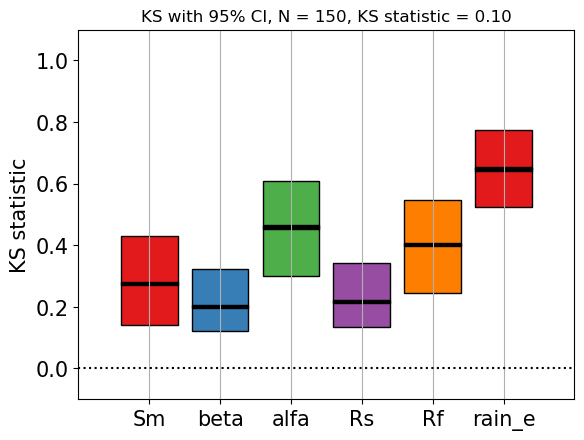

In [14]:
threshold = 0.1
Nboot = 1000

mvd, _, _, idxb = RSA_tr.RSA_indices_thres(X, YY[:, 2], threshold = threshold, Nboot=Nboot)

alfa = 0.05 # Significance level for the confidence intervals estimated by
# bootstrapping (default value is 0.05)
mvd_m, mvd_lb, mvd_ub = aggregate_boot(mvd, alfa=alfa) # shape (M,)

# The sensitivity indices with their 95% confidence intervals are plotted:
plt.figure()
pf.boxplot1(mvd_m, S_lb=mvd_lb, S_ub=mvd_ub, X_Labels=X_Labels, \
            Y_Label='KS statistic')
plt.title("KS with 95%% CI, N = %d" % N + ", " + "KS statistic" + " = %2.2f" % threshold)
plt.show()

**Questions:**
- Is the sample size large enough? Why?


Now choose the number of new samples to be added (N_new) and re-run the analysis:

In [15]:
# Choose the number of samples to be added:
N_new = 2000 # size of new samples
N2 = N_new + N # total sample size

# Add new samples:
X_N2 = AAT_sampling_extend(X, distr_fun, distr_par, N2)

AAT_sampling_extend allows to extend an existing sample by choosing additional samples that maximise the spread in the input space X_N2 is the extended sample (it includes the already evaluated samples 'X' and the new ones)

In [16]:
# Check the shape is X_N2:
print(X_N2.shape)

# Extract new samples:
X_new = X_N2[N:N2, :]
# Check the shape of X_new:
print(X_new.shape) 

(2150, 6)
(2000, 6)


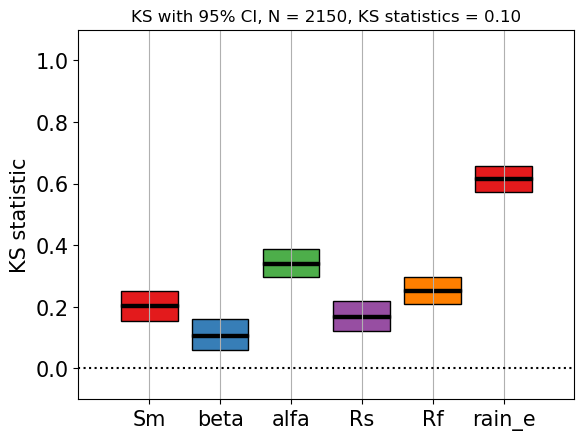

In [17]:
# Execute the model against the new inputs samples (WARNING: it may take
# some time to run this line):
QQ_new = model_execution(hymod_sim_workshop_mod, X_new, rain, evap)

# Aggregate time series into the scalar metric
HFD_new = np.sum(QQ_new >= Q95obs, axis = 1)/365
# Use the function RSA_indices_thres to split into behavioural (Y<threshold)

# Combine old and new output samples:
YY_N2 = np.concatenate((HFD, HFD_new))

mvd_new, _, _, idxb = RSA_tr.RSA_indices_thres(X_new, HFD_new, threshold = threshold, Nboot=Nboot)

alfa = 0.05 # Significance level for the confidence intervals estimated by
# bootstrapping (default value is 0.05)
mvd_m1, mvd_lb1, mvd_ub1 = aggregate_boot(mvd_new, alfa=alfa) # shape (M,)

# The sensitivity indices with their 95% confidence intervals are plotted:
plt.figure()
pf.boxplot1(mvd_m1, S_lb=mvd_lb1, S_ub=mvd_ub1, X_Labels=X_Labels, \
            Y_Label='KS statistic')
plt.title("KS with 95%% CI, N = %d" % N2 + ", " + "KS statistics" + " = %2.2f" % threshold)
plt.show()



**Questions:**
- Has the ranking of the input factors changed? 
- Is the sample size large enough now? 
- What are the implications of these results in terms of prioritising efforts for data acquisition to improve the model prediction ability?

In [18]:
NN = np.array([150, 300, 500, 1000, 1500, 2150]) # increasing sample sizes
Nboot = 100 # Number of resamples used for bootstrapping (suggested value 
# is 100 for the purpose of this exercise to  limit computational time, but 
# the recommended value for a rigorous analysis is 1000)
mvd_cvg, _, _ = RSA_tr.RSA_convergence_thres(X_N2, YY_N2, NN, threshold, Nboot=Nboot)
# mvd, spread and irr have shape (Nboot, M)

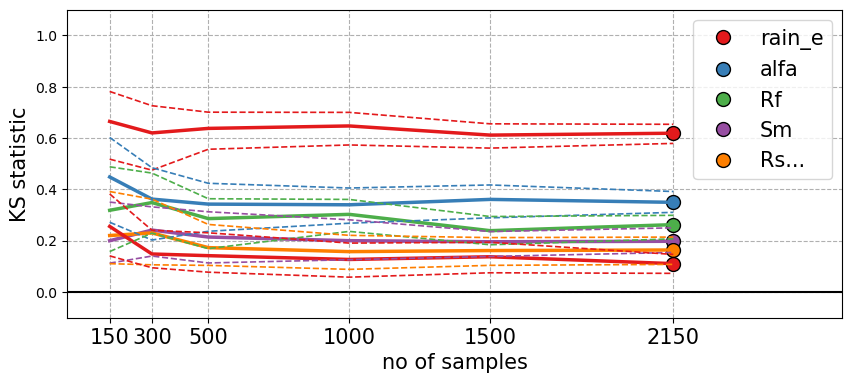

In [19]:
mvd_cvg_m, mvd_cvg_lb, mvd_cvg_ub = aggregate_boot(mvd_cvg) # shape (R,M)
# Plot the sensitivity measures as a function of the number of samples:
plt.figure()
pf.plot_convergence(mvd_cvg_m, NN, mvd_cvg_lb, mvd_cvg_ub, X_Label='no of samples',
                    Y_Label='KS statistic', labelinput=X_Labels)
hfig_cdfs = plt.gcf() # get figure handle
hfig_cdfs.set_size_inches(10, 4) # set width and height 
plt.show()

**Questions:**
- Has convergence been reached? Why?

-------------------------------------------------------------------------------

The notebook uses the [SAFE(R/Python/Matlab) Toolbox](https://safetoolbox.github.io) (Pianosi et al., 2015). 

Interactive visualisations have been modified from Fanny Sarrazin and Andres Peñuela's notebook 
https://github.com/AndresPenuela


**Further reading**:

Noacco et al.(2019) discusses the key choices in setting up GSA, a general discussion on the topic is also provided in Pianosi et al. (2016) and in Wagener and Pianosi (2019). The choice of sample size is more specifically discussed in Sarrazin et al. (2016).


**References**:

Boyle, D. (2001). Multicriteria calibration of hydrological models. PhD thesis. 
University of Arizona, Tucson.

Noacco et al. (2019). Matlab/R workflows to assess critical choices in
Global Sensitivity Analysis using the SAFE toolbox. MethodsX. 6. 2258-2280.

Pianosi et al. (2015). A Matlab toolbox for Global Sensitivity Analysis.
Environmental Modelling and Software. 70. 80-85.

Pianosi et al. (2016). Sensitivity analysis of environmental models:
A systematic review with practical workflow. Environmental Modelling and
Software. 79. 214-232.

Saltelli et al. (2008). Global Sensitivity Analysis, The Primer, John Wiley
Sons. Ltd. Chichester, UK.

Sarrazin et al. (2016). Global Sensitivity Analysis of environmental models:
Convergence and validation. Environmental Modelling and Software. 79.
135-162.

Sorooshian at al. (1983). Evaluation of maximum likelihood parameter
estimation techniques for conceptual rainfall-runoff models: Influence of
calibration data variability and length on model credibility. Water Resour.
Res. 19. 251-259.

Spear and Hornberger (1980). Eutrophication in peel inlet e II.
Identification of critical uncertainties via generalized sensitivity analysis.
Water Research. 14(1). 43-49.

Wagener et al. (2001). A framework for development and application of
hydrological models. Hydrol. Earth Syst. Sci.. 5. 13-26.

Wagener and Pianosi (2019). What has Global Sensitivity Analysis ever done for 
us? A systematic review to support scientific advancement and to inform policy-
making in earth system modelling. Earth-Science Reviews. 194. 1-18.

Young et al. (1978). Modelling badly defined systems: some further thoughts.
In: Proceedings SIMSIG Conference. Canberra. 24-32.